In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cPickle as pickle
import lasagne
import sys
sys.path.append('../')

from models.AD import AD

In [3]:
# some initial stuff
seed = 3
np.random.seed(seed)
params_task = {}
params_task['task'] = 'sepsis_controller'
params_task['seed'] = seed

In [4]:
# load the data
dire = '../environment/out/' 

X_train = np.loadtxt(dire+'X_train.txt')
Y_train = np.loadtxt(dire+'Y_train.txt')
X_test = np.loadtxt(dire+'X_val.txt')
Y_test = np.loadtxt(dire+'Y_val.txt')

In [5]:
# load in the saved factors for the rewards
sofa_mean = float(np.load('../../data/sofa_mean.npy'))
sofa_std = float(np.load('../../data/sofa_std.npy'))
lact_mean = float(np.load('../../data/lact_mean.npy'))
lact_std = float(np.load('../../data/lact_std.npy'))

# load in the state vector so we know what indices SOFA and lactate are stored at
state_vec = list(np.loadtxt('../../data/state_features.txt', dtype=str))

sofa_index = state_vec.index('SOFA')
lact_index = state_vec.index('Arterial_lactate')

In [6]:
print sofa_mean, sofa_std, lact_mean, lact_std

6.32323667365 3.49480112336 2.01549668201 1.52264007734


In [8]:
# restore the saved BNN model
dire = 'models/'
alpha = "0.5"
fstr = 'AD_'+alpha+ '.p'
params_model = pickle.load(open(dire+fstr,'rb'))['params_model']
params_model['saved'] = dire+fstr

# load the model
print params_model['saved']
model = AD(params_model,params_task,X_train,Y_train, X_test, Y_test)
model.loadWeights() 

models/AD_0.5.p
[51, 100, 100, 42]


In [9]:
# roughly, code:
# Run the BNN for X steps, resample noise. Grab predicted means for each sample for each timestep for each feature
# Extract SOFA and lactate -- the two important features
# Compute NEW VALUES; the output is the CHANGE IN THE VALUES!!!!!
# Unscale these two: val * std_dev + mean
# Compute the mean of the unscaled samples on a per timestep basis (average across draws from the posterior)
# Resample on a per timestep basis from the collection of draws from the posterior. N draws from posterior -->
# each resample has N elems
# For each resample, compute delta_star = mean(resample, per_timestep) - mean(orig samples). 
# Sort delta_star; take elem 9499 and elem 499 on a per-timestep basis to form the CI bounds
# For each timestep, plot: mean_orig, mean_orig-delta_95, mean_orig-delta_5.

In [10]:
# as test: extract first 14 rows of train -- X_train[:14] and first 11 points of X_val: X_val[:11]

In [11]:
train_batch = X_train[:14]
val_batch = X_test[:11]

In [12]:
df = pd.read_csv('../../data/rl_train_set_unscaled.csv')

In [13]:
df = df.iloc[:14]

In [14]:
sofa_index

29

In [15]:
train_batch.shape

(14, 50)

In [16]:
def sofa_evolution_plot_per_timestep(df_batch, batch):
    n_samples = 1
    model.bb_alpha.network.update_randomness(n_samples)
    
    # NOTE: model predicts change from timestep t to timestep t+1 
    # need to add these on to the actual data points!
    m,_ = model.predict(np.tile(batch,[n_samples,1,1]))
    
    # extract predicted change in sofa, unscale
    m_sofa = m[:, :, sofa_index]*sofa_std
    
    # These are the points in the actual dataset
    sofa_scores = df_batch['SOFA'].values
    sofa_scores = sofa_scores*sofa_std + sofa_mean
    
    # after line below, m_sofa is the predicted sofa at the next timestep
    m_sofa += sofa_scores
    
    # calculate the mean across the BNN samples
    m_sofa_mean = np.mean(m_sofa, axis=0)
    for i in zip( np.mean(m[:, :, sofa_index], axis=0), Y_train[:14, sofa_index]):
        print i
#     return
    deltas = []
    for t in range(m_sofa.shape[1]):
        resampled = np.random.choice(m_sofa[:,t], size=(10000,n_samples))
        resampled_mean = np.mean(resampled, axis=1)
        dstar = resampled_mean - m_sofa_mean[t]
        deltas.append(dstar)
    deltas = np.array(deltas)
    deltas_05 = deltas[:, 9499]
    deltas_95 = deltas[:, 499]
    
    # for confidence intervals
    lb = m_sofa_mean - deltas_05
    ub = m_sofa_mean - deltas_95
    
    # m_sofa_mean, lb, ub all go from timestep t=1 to t=Traj_end+1
    # sofa_scores go from t=0 to t=Traj_end
    # plot accordingly
    pred_index = range(1,len(batch)+1)
    actual_index = range(0,len(batch))
    
    real_targets = sofa_scores + (sofa_std*Y_train[:14, sofa_index])
    
    plt.plot(pred_index, m_sofa_mean)
    plt.fill_between(pred_index, lb,  
                     ub, color='#ADD8E6')
    plt.plot(actual_index, sofa_scores) 
    plt.plot(pred_index, real_targets)
    
    for i in zip(m_sofa_mean, sofa_scores, real_targets):
        print i


HERE
(0.14618953496523379, -0.28610000000000002)
(0.16579169756884549, -0.28610000000000002)
(1.3257705000001434, -0.28610000000000002)
(0.11612789819564033, -0.28610000000000002)
(-0.12468530326411353, 0.85840000000000005)
(-0.34638844086991261, 1.4307000000000001)
(-0.22358357736781856, -0.57230000000000003)
(0.15687385792772218, -0.85840000000000005)
(-0.036781239697837788, 0.85840000000000005)
(-0.14030727712648791, 0.0)
(-0.19110367065772407, 0.0)
(-0.14147766137079912, 0.0)
(-0.11632410257866427, 0.0)
(0.22733494431483894, -0.28610000000000002)
(9.5109033510199286, 8.9999999999995097, 8.0001373986053466)
(8.5794090109072894, 7.9999999999994245, 7.0001373986052604)
(11.633304232721411, 6.9999999999993392, 6.0001373986051751)
(6.4058439090678645, 5.9999999999999529, 5.0001373986057889)
(4.564249662084884, 4.9999999999991687, 7.9999372842939964)
(6.7894412877272838, 7.9999999999994245, 13.000011967194915)
(12.218619862635295, 12.999999999985873, 10.999925317085209)
(11.5482429349187

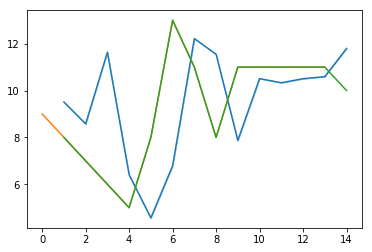

In [17]:
sofa_evolution_plot_per_timestep(df,train_batch)

In [248]:
print df.loc[1, 'SOFA']*sofa_std + Y_train[1,sofa_index]*sofa_std + sofa_mean

7.00013739861


In [249]:
print X_train[0]

[-0.3477 -1.0931  2.0258 -0.3647 -0.0616 -1.3743 -0.9994 -0.3279 -0.3174
  0.1119  2.4003  0.7711 -0.5605 -0.3157  2.0355  0.6278  1.5671 -0.8719
 -2.3569 -0.9913  1.1483 -0.2031 -1.0304 -0.8884 -1.7178  2.0418 -0.0818
  0.4111  2.2784  0.7659  2.4987  0.2603 -0.1879 -1.142   1.9456  1.3176
  0.3345 -0.2181 -0.9736 -1.8038 -0.5    -0.5     0.4229 -0.3765 -0.7665
 -0.5879 -0.5    -2.3116  0.8    -0.8   ]


In [254]:
print df[state_vec].values[0]

[-0.34769535 -1.09309218  2.02575997 -0.36474368 -0.06160668 -1.37431257
 -0.99938172 -0.32791879 -0.31735819  0.11191742  2.40025873  0.77113175
 -0.56047275 -0.31567671  2.03549534  0.6278409   1.56711666 -0.87188875
 -2.35693612 -0.99129205  1.14829258 -0.20312503 -1.03042843 -0.88836621
 -1.7177655   2.041844   -0.08180852  0.41109717  2.27842128  0.76592723
  2.49873352  0.26034904 -0.18793172 -1.14202951  1.94561009  1.31756146
  0.33446219 -0.21812426 -0.97355177 -1.80382573 -0.5        -0.5
  0.42293671 -0.37647854 -0.76647805 -0.58790611 -0.5        -2.31157255]


In [244]:
sofa_scores = df['SOFA'].values
sofa_scores = sofa_scores*sofa_std + sofa_mean
print sofa_scores

[  9.   8.   7.   6.   5.   8.  13.  11.   8.  11.  11.  11.  11.  11.]


In [256]:
print Y_train[0][:-1] + X_train[0][:-2]

[-0.3477 -1.0931  2.0258 -0.3647 -0.0616 -1.3743 -0.9994 -0.3279 -0.3174
  0.2469  2.4003  0.7711 -0.5605 -0.3157  1.5108  0.6278  1.5671 -0.8719
 -2.3569 -0.8434  1.1483 -0.2031 -1.0304 -0.8884 -1.7178  2.3798 -0.0818
  0.4111  1.3348  0.4798  2.2732  0.2603 -1.2355 -1.3144  0.6021  1.3176
  0.3345 -0.2181 -0.9736 -1.8038 -0.5    -0.5     0.6456 -0.0375 -0.7665
 -0.5879 -0.5    -1.4723]


In [255]:
print X_train[1]

[-0.3477 -1.0931  2.0258 -0.3647 -0.0616 -1.3743 -0.9994 -0.3279 -0.3174
  0.2469  2.4003  0.7711 -0.5605 -0.3157  1.5108  0.6278  1.5671 -0.8719
 -2.3569 -0.8433  1.1483 -0.2031 -1.0304 -0.8884 -1.7178  2.3799 -0.0818
  0.4111  1.3348  0.4798  2.2733  0.2603 -1.2355 -1.3144  0.6021  1.3176
  0.3345 -0.2181 -0.9736 -1.8038 -0.5    -0.5     0.6457 -0.0375 -0.7665
 -0.5879 -0.5    -1.4723  0.8    -0.8   ]


In [175]:
df.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,-2.311573,3,7245052800,-0.5,-0.973552,-1.803826,-0.5,0,1,-0.218124,...,0.0,-0.378832,0.139523,1.257985,-0.376479,0.422937,0.097512,0.0,4.0,0
1,-1.472264,3,7245067200,-0.5,-0.973552,-1.803826,-0.5,0,1,-0.218124,...,0.0,-0.378832,0.324790,1.243446,-0.037480,0.645655,0.326743,0.0,4.0,0
2,-0.966747,3,7245081600,-0.5,-0.973552,-1.803826,-0.5,0,1,-0.218124,...,0.0,-0.378832,0.332546,0.374560,0.327893,1.033948,0.102300,0.0,2.0,0
3,-0.603852,3,7245096000,-0.5,-0.973552,-1.803826,-0.5,0,1,-0.218124,...,0.0,-0.378832,0.336913,0.209693,0.400830,0.734782,0.018508,0.0,2.0,0
4,-0.320563,3,7245110400,-0.5,-0.973552,-1.803826,-0.5,0,1,-0.218124,...,0.0,-0.378832,0.341234,0.209693,0.442817,0.619696,-0.036855,0.0,2.0,0


In [180]:
df_orig = pd.read_csv('../../data/MKdataset07Feb17.csv')

In [181]:
df_orig_icu3 = df_orig[df_orig['icustayid']==3]
df_orig_icu3['SOFA']

0      9
1      8
2      7
3      6
4      5
5      8
6     13
7     11
8      8
9     11
10    11
11    11
12    11
13    11
Name: SOFA, dtype: int64

In [179]:
df_train = pd.read_csv('../../data/rl_train_set_unscaled.csv')

In [182]:
df_orig_tmp = df_orig[df_orig['icustayid'].isin(df_train['icustayid'].unique())]